# Evaluation wrt GT

In [1]:
import numpy as np
import pandas as pd
import os
import pprint

from evo.core.trajectory import PoseTrajectory3D
from evo.tools import plot
from evo.core import metrics

import matplotlib.pyplot as plt
from pose_trajectory_evaluation import PoseTrajectoryEvaluation

%matplotlib inline
# %matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [24]:
merged_map_path = '/tmp/maplab_server/merged_map/'
gt_path = '/home/berlukas/Documents/results/hagerbach_july/mission_05_opt/'

pose_filename = 'vertex_poses_velocities_biases.csv'
est_traj_file = merged_map_path + pose_filename
gt_traj_file = gt_path + pose_filename

header_names = ['timestamp [ns]', 'vertex-id', 'mission-id', 'p_G_Ix [m]', 'p_G_Iy [m]', 'p_G_Iz [m]', 'q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz', 'p_M_Ix [m]', 'p_M_Iy [m]', 'p_M_Iz [m]', 'q_M_Iw', 'q_M_Ix', 'q_M_Iy', 'q_M_Iz', 'v_Mx [m/s]', 'v_My [m/s]', 'v_Mz [m/s]', 'bgx [rad/s]', 'bgy [rad/s]', 'bgz [rad/s]', 'bax [m/s^2]', 'bay [m/s^2]', 'baz [m/s^2]']

est_df = pd.read_csv(est_traj_file, names=header_names, delimiter=',', comment='#', header=None)
gt_df = pd.read_csv(gt_traj_file, names=header_names, delimiter=',', comment='#', header=None)

print(f'Read {int(est_df.size/len(header_names))} est and {int(gt_df.size/len(header_names))} gt entries.')

Read 498 est and 7644 gt entries.


In [25]:
missions = np.array(pd.unique(est_df['mission-id']))
n_mission = missions.shape[0]
print(f'We have {n_mission} estimated mission(s).')

synced_gt_df = gt_df[gt_df['mission-id'].isin(missions)]
print(f'Synced {len(pd.unique(synced_gt_df["mission-id"]))} mission with the GT.')



We have 1 estimated mission(s).
Synced 1 mission with the GT.


In [19]:
def convert_df_to_traj(df):
    ts = df['timestamp [ns]'].to_numpy()
    xyz = df[['p_G_Ix [m]', 'p_G_Iy [m]', 'p_G_Iz [m]']].to_numpy()
    wxyz = df[['q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz']].to_numpy()
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

est_traj = convert_df_to_traj(est_df)
gt_traj = convert_df_to_traj(synced_gt_df)

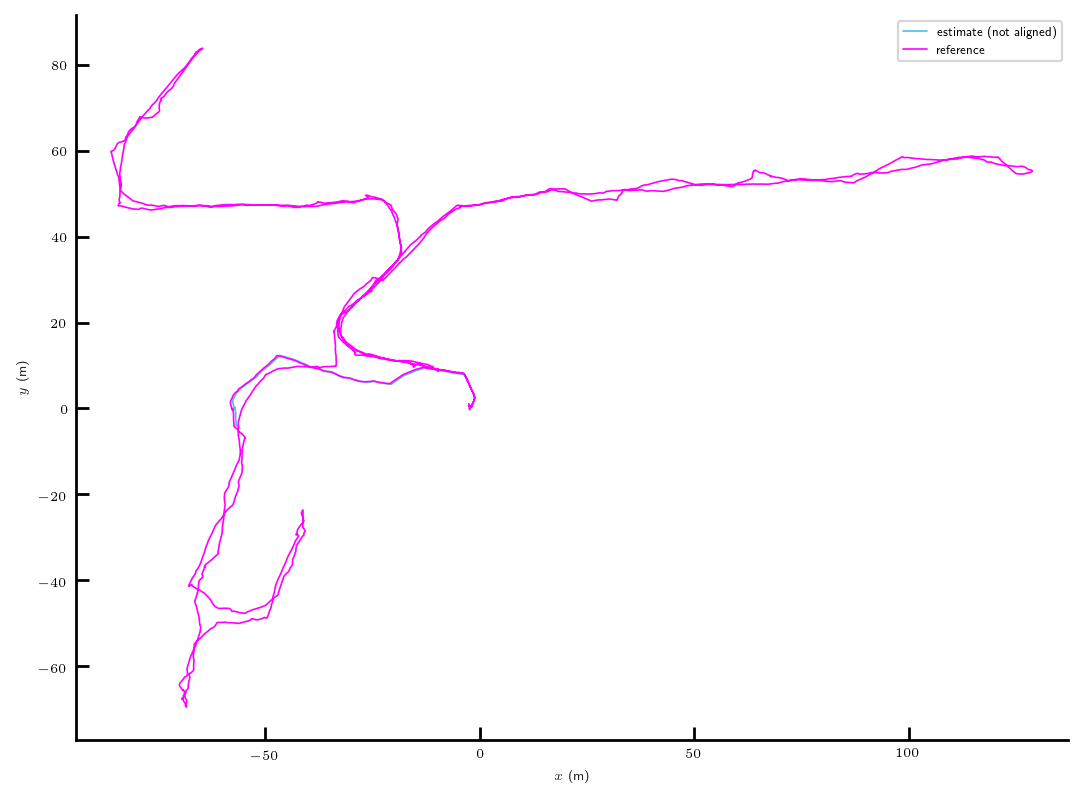

In [20]:
fig = plt.figure(figsize=(8, 6), dpi=160)
traj_by_label = {
    "estimate (not aligned)": est_traj,
#     "estimate (aligned)": traj_est_aligned,
    "reference": gt_traj
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()

In [14]:
pose_relation = metrics.PoseRelation.translation_part
data = (gt_traj, est_traj)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

1.3450756514590463
{'max': 3.4412160141018844,
 'mean': 0.9637933156282693,
 'median': 0.7037194202240802,
 'min': 0.004210635618029109,
 'rmse': 1.3450756514590463,
 'sse': 5333.6056420202385,
 'std': 0.9382595338701575}


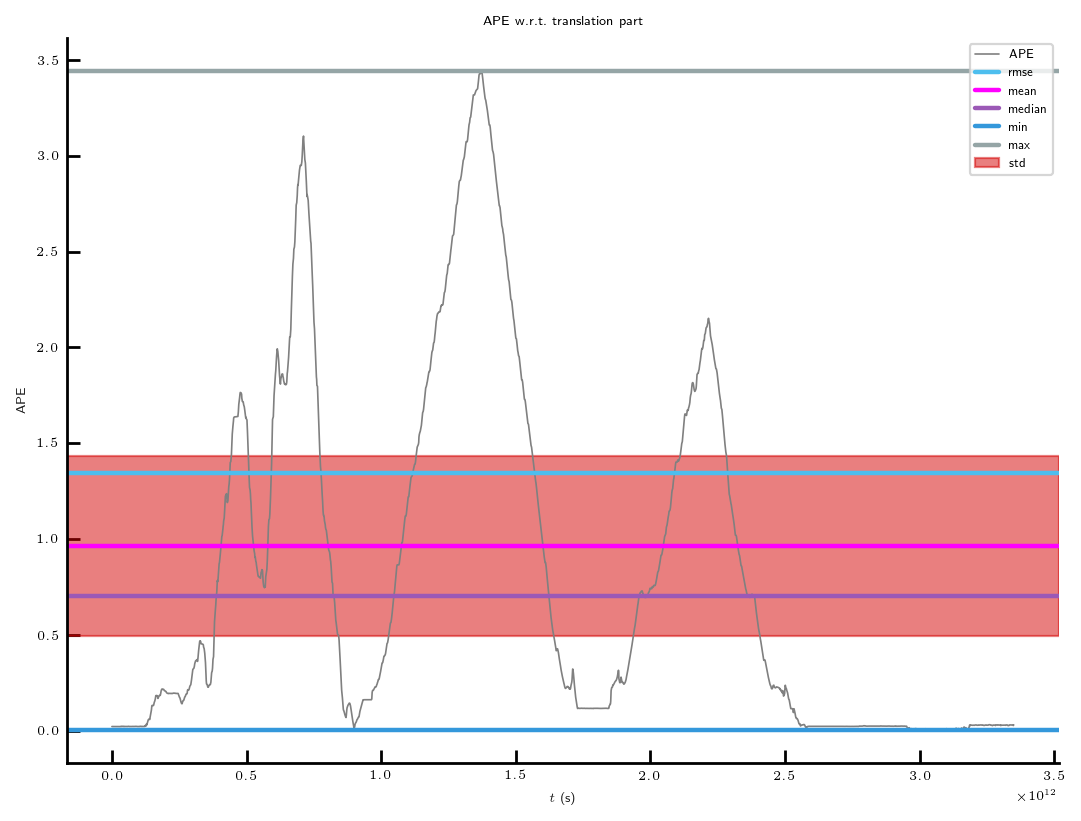

In [19]:
seconds_from_start = [t - est_traj.timestamps[0] for t in est_traj.timestamps]
fig = plt.figure(figsize=(8, 6), dpi=160)
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

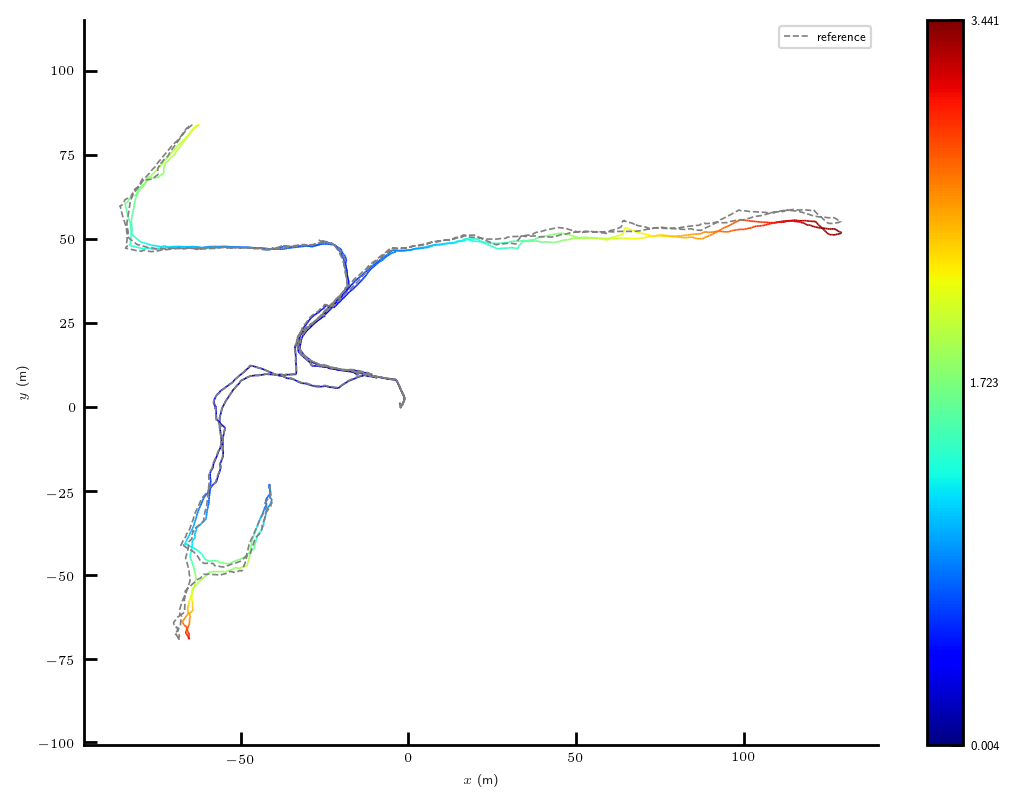

In [22]:
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(8, 6), dpi=160)
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
plot.traj_colormap(ax, est_traj, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

In [30]:
eval = PoseTrajectoryEvaluation(est_traj_file, gt_traj_file)
est_traj, gt_traj = eval.compute_synchronized_trajectories()
print(f'we have an rmse of {eval.compute_ape()}')

we have an rmse of 1.5672734235086676


In [31]:
est_xyz = est_traj[:, 1:4]
gt_xyz = gt_traj[:, 1:4]

err = np.linalg.norm(est_xyz - gt_xyz, axis=1)
rmse = np.sqrt(np.mean(err**2))
print(f'we have an rmse of {rmse}')

we have an rmse of 1.5672734235086676


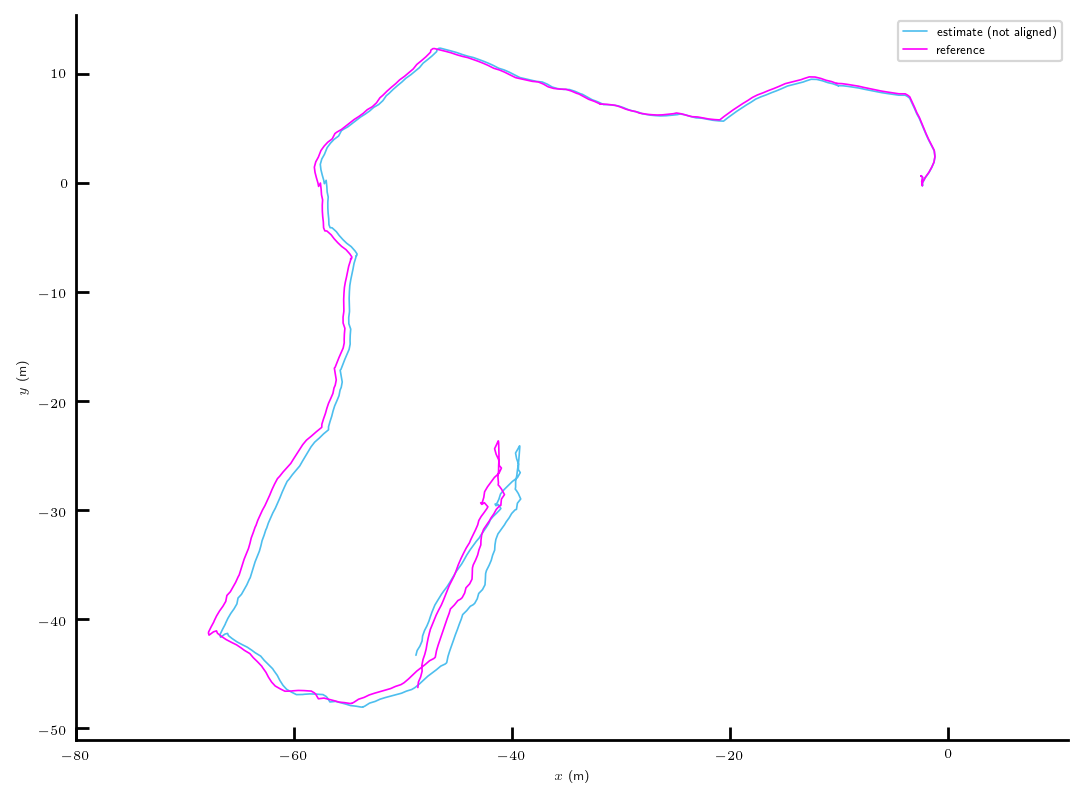

In [29]:
def convert_traj_to_evo_traj(traj):
    return PoseTrajectory3D(positions_xyz = traj[:,1:4], orientations_quat_wxyz = traj[:,4:8], timestamps = traj[:,0])

est_evo_traj = convert_traj_to_evo_traj(est_traj)
gt_evo_traj = convert_traj_to_evo_traj(gt_traj)

fig = plt.figure(figsize=(8, 6), dpi=160)
traj_by_label = {
    "estimate (not aligned)": est_evo_traj,
    "reference": gt_evo_traj
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()